### Multi Layer Perceptron: Bengio, Ducharme, Vincent and Jauvin

This paper represent a word level language model, where they took around 17000 words and then they associate each word with 30 dimensional feature vector.

So every word is embedded into 30 dimensional space. So we have 17000 vectors in 30 dimensional space. Initially these words are spread out randomly in the vector space. But then we tune these embeddings (of each word) with back-propagation.

They are using max log-likelhood as the loss function.


### Talking about the model architecture

We have a look-up table which has 17000 rows (the number of words) and 30 columns (representing the features).

The size of the middle layer is a hyper-parameter which can be changed based on the context of number of words to be inputed.

We have 17000 logits out into the softmax function with each giving the probability of the next word prediction.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [3]:
words = open('datasets/names.txt').read().splitlines()
print(words[:10])  # Print the first 10 words to verify
print(f"Total words loaded: {len(words)}")

chars = sorted(list(set(''.join(words))))

# string to index mapping 
stoi = { ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
print(f"String to index mapping: {stoi}")

itos = {i:s for s,i in stoi.items()}
print(itos)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Total words loaded: 32033
String to index mapping: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We will train, build our training dataset where given 3 input characters it should predict the next character.

In [4]:
X,Y = [],[]

block_size = 3

for w in words[:5]:

    context = [0] * block_size
    print(w)

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

# print(X)
X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
X.shape ,X.dtype ,Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Now as given in the paper each word was represented as a vector embedding of size 30, so around 17000 words are represented in this 30 dimension space.

Here the total possible outcomes are about 27 (the characters + '.') so we will have 2 dimension for each letter.

In [6]:
C = torch.randn((27,2))
C

tensor([[-0.5317,  1.0762],
        [ 0.8327, -0.2673],
        [ 0.5374, -1.0052],
        [ 0.2454, -0.5140],
        [ 1.4360,  0.4973],
        [ 2.2075, -0.8008],
        [ 2.0018,  0.2471],
        [-1.9234,  0.4276],
        [ 0.8014,  0.1547],
        [ 1.0859, -1.2026],
        [ 1.7658, -2.4558],
        [ 0.1689,  1.4641],
        [-0.4662, -0.0187],
        [-0.9960, -1.5599],
        [ 0.0802,  1.1599],
        [-0.3862,  0.0737],
        [ 0.9456,  0.3073],
        [-0.1905,  0.4287],
        [ 0.7314,  0.1582],
        [ 1.0307,  0.0480],
        [-1.2171,  0.1924],
        [-0.0273, -0.0328],
        [-0.3643, -2.0127],
        [-0.4401, -0.3165],
        [-0.0381, -0.6739],
        [ 0.3533,  0.1788],
        [-2.3815, -0.2602]])

So for each input [0,1,2] we will get the dimension vector

0 -> [0.123, -1.34]    
1 -> [-0.45, 1.03]   
2 -> [0.03, -0.56]   


In [7]:
C[0], C[1], C[2]

(tensor([-0.5317,  1.0762]),
 tensor([ 0.8327, -0.2673]),
 tensor([ 0.5374, -1.0052]))

Pytorch does not know how to multiply float with an int.

In [8]:
# Another way

F.one_hot(torch.tensor(0),num_classes=27).float() @ C

tensor([-0.5317,  1.0762])

So in the first layer we feed these one hot encoded value (i/p) to C matrix which is nothing but weights, but here we will index as its much more faster.

In [9]:
C[[1,2,3]]
# X[14,2]

tensor([[ 0.8327, -0.2673],
        [ 0.5374, -1.0052],
        [ 0.2454, -0.5140]])

In [10]:
# so we can convert each of the indexs into vector embeddings just doing

embedded_ip = C[X]

In [11]:
print(embedded_ip.shape)
embedded_ip

torch.Size([32, 3, 2])


tensor([[[-0.5317,  1.0762],
         [-0.5317,  1.0762],
         [-0.5317,  1.0762]],

        [[-0.5317,  1.0762],
         [-0.5317,  1.0762],
         [ 2.2075, -0.8008]],

        [[-0.5317,  1.0762],
         [ 2.2075, -0.8008],
         [-0.9960, -1.5599]],

        [[ 2.2075, -0.8008],
         [-0.9960, -1.5599],
         [-0.9960, -1.5599]],

        [[-0.9960, -1.5599],
         [-0.9960, -1.5599],
         [ 0.8327, -0.2673]],

        [[-0.5317,  1.0762],
         [-0.5317,  1.0762],
         [-0.5317,  1.0762]],

        [[-0.5317,  1.0762],
         [-0.5317,  1.0762],
         [-0.3862,  0.0737]],

        [[-0.5317,  1.0762],
         [-0.3862,  0.0737],
         [-0.4662, -0.0187]],

        [[-0.3862,  0.0737],
         [-0.4662, -0.0187],
         [ 1.0859, -1.2026]],

        [[-0.4662, -0.0187],
         [ 1.0859, -1.2026],
         [-0.3643, -2.0127]],

        [[ 1.0859, -1.2026],
         [-0.3643, -2.0127],
         [ 1.0859, -1.2026]],

        [[-0.3643, -2

In [12]:
# As our neural network will take 3 letters at a time, hence the no. inputs will be 6.

W1 = torch.randn((6,100)) # 100 neurons with 6 intakes each.
b1 = torch.randn(100) 

# 227 neurons 
W2 = torch.rand((100,27))
b2 = torch.rand(27)


To get the output from each of the 100 neurons I want to do 

embbedded_ip @ W + b 

But the embbedded_ip shape is of (32, 3, 2) we will convert this to (32,6).

### Method-1   torch.cat()

New memory is being created, we use this to get our matrix.

In [13]:
print(embedded_ip[:,0,:].shape)
embedded_ip[:,0,:]

torch.Size([32, 2])


tensor([[-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 2.2075, -0.8008],
        [-0.9960, -1.5599],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.3862,  0.0737],
        [-0.4662, -0.0187],
        [ 1.0859, -1.2026],
        [-0.3643, -2.0127],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 0.8327, -0.2673],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 1.0859, -1.2026],
        [ 1.0307,  0.0480],
        [ 0.8327, -0.2673],
        [ 0.5374, -1.0052],
        [ 2.2075, -0.8008],
        [-0.4662, -0.0187],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 1.0307,  0.0480],
        [-0.3862,  0.0737],
        [ 0.9456,  0.3073],
        [ 0.8014,  0.1547]])

In [14]:
emb_vec_ip = torch.cat([embedded_ip[:,0,:], embedded_ip[:,1,:], embedded_ip[:,2,]], 1)
print(emb_vec_ip.shape)
emb_vec_ip[:5,:]

torch.Size([32, 6])


tensor([[-0.5317,  1.0762, -0.5317,  1.0762, -0.5317,  1.0762],
        [-0.5317,  1.0762, -0.5317,  1.0762,  2.2075, -0.8008],
        [-0.5317,  1.0762,  2.2075, -0.8008, -0.9960, -1.5599],
        [ 2.2075, -0.8008, -0.9960, -1.5599, -0.9960, -1.5599],
        [-0.9960, -1.5599, -0.9960, -1.5599,  0.8327, -0.2673]])

### Method-2 torch.unbind()

In [15]:
# this gives 1st letter dimensions for each of the input data (0th index letter)
torch.unbind(embedded_ip,1)[0]

tensor([[-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 2.2075, -0.8008],
        [-0.9960, -1.5599],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.3862,  0.0737],
        [-0.4662, -0.0187],
        [ 1.0859, -1.2026],
        [-0.3643, -2.0127],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 0.8327, -0.2673],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 1.0859, -1.2026],
        [ 1.0307,  0.0480],
        [ 0.8327, -0.2673],
        [ 0.5374, -1.0052],
        [ 2.2075, -0.8008],
        [-0.4662, -0.0187],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [-0.5317,  1.0762],
        [ 1.0307,  0.0480],
        [-0.3862,  0.0737],
        [ 0.9456,  0.3073],
        [ 0.8014,  0.1547]])

In [16]:
emb_vec_ip = torch.cat(torch.unbind(embedded_ip,1),1)

print(emb_vec_ip.shape)
emb_vec_ip[:5,:]

torch.Size([32, 6])


tensor([[-0.5317,  1.0762, -0.5317,  1.0762, -0.5317,  1.0762],
        [-0.5317,  1.0762, -0.5317,  1.0762,  2.2075, -0.8008],
        [-0.5317,  1.0762,  2.2075, -0.8008, -0.9960, -1.5599],
        [ 2.2075, -0.8008, -0.9960, -1.5599, -0.9960, -1.5599],
        [-0.9960, -1.5599, -0.9960, -1.5599,  0.8327, -0.2673]])

### Method - 3 torch.view()

In [17]:
# This is much more efficient as it does not create new memory, it works on few internal 
# attributes like sizes, stride, storage_offset which are changed/manipulated.

print(embedded_ip.view(embedded_ip.shape[0],6)[:5,:])

embedded_ip.view(embedded_ip.shape[0],6) == torch.cat(torch.unbind(embedded_ip,1),1)

tensor([[-0.5317,  1.0762, -0.5317,  1.0762, -0.5317,  1.0762],
        [-0.5317,  1.0762, -0.5317,  1.0762,  2.2075, -0.8008],
        [-0.5317,  1.0762,  2.2075, -0.8008, -0.9960, -1.5599],
        [ 2.2075, -0.8008, -0.9960, -1.5599, -0.9960, -1.5599],
        [-0.9960, -1.5599, -0.9960, -1.5599,  0.8327, -0.2673]])


tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Note we are broadcasting here

-> Align the b vector dimension to the right
32, 100
 1, 100  

Now this (1, 100) will be replicated vertically.

In [18]:
print((emb_vec_ip @ W1).shape)
print(b1.shape) 

torch.Size([32, 100])
torch.Size([100])


In [19]:
# embedded_ip.shape[0] is the input size of the training data.
emb_vec_ip = embedded_ip.view(embedded_ip.shape[0],6) 

h = torch.tanh(emb_vec_ip @ W1 + b1)
print(h.shape)
h[:2,:]

torch.Size([32, 100])


tensor([[ 0.6227, -0.9843,  0.9818,  0.9997, -1.0000, -0.3739, -0.4078, -0.9967,
         -0.4769, -0.9074,  0.6798, -0.9601,  0.9333, -0.9709,  0.9968,  0.9373,
          0.9965,  0.7756, -0.7124,  0.5962,  0.9992, -0.9861,  0.6519,  0.8538,
         -0.9032, -0.9293, -0.3865, -0.7357, -0.9851, -0.9588,  0.9135, -0.9966,
         -0.9952, -0.6294, -0.7944,  0.4104, -0.0331, -0.4840,  0.7555, -0.9999,
         -0.8878,  0.9947,  0.0682, -0.9910,  0.9803,  0.8856,  0.6401, -0.2485,
         -0.4296, -0.4592, -0.9971,  0.9999, -0.9910,  0.9833,  1.0000, -0.3718,
          0.4753, -0.5511, -0.9955, -0.9999,  0.9951, -0.9905,  0.4431,  0.9435,
         -0.9866, -0.9964,  0.8877,  0.8906, -0.9968,  0.7449, -0.2473, -0.9808,
          0.9691, -0.9984, -0.9525, -0.1473,  0.5721,  0.8968, -0.8524,  0.9388,
          0.2287,  0.4983, -0.9926, -0.9986, -0.9963,  0.8688,  0.9956, -0.9999,
         -0.5996, -0.9911, -0.5658, -0.7631,  0.9627, -0.9556,  0.4237,  0.9925,
          0.9914, -0.0848,  

In [20]:
# 227 neurons 
W2 = torch.rand((100,27))
b2 = torch.rand(27)

In [21]:
logits = h @ W2 + b2
print(logits.shape)

torch.Size([32, 27])


In [22]:
# For each of the input we have Predicted the next character.
counts = logits.exp()

prob = counts/counts.sum(1,keepdims=True)

Jo bhi target values hain, we will get the probability predicted by our model and then multiply all the probabilities, now in each epoch we will try to maximize this log-likelihood (probability) or minimize the negative log-likelihood.

In [23]:
print(Y.shape)
prob[torch.arange(32), Y]

torch.Size([32])


tensor([3.7962e-04, 6.5592e-04, 2.4608e-03, 1.1106e-02, 1.0245e-04, 4.3816e-04,
        3.3635e-03, 2.9080e-04, 3.1495e-02, 1.0232e-02, 4.9791e-02, 2.2812e-04,
        7.0619e-05, 1.7395e-01, 1.8659e-02, 6.2527e-05, 1.2428e-04, 1.1530e-03,
        7.0597e-04, 9.4952e-05, 3.9887e-01, 8.7194e-02, 9.6210e-04, 5.6681e-05,
        1.4866e-03, 1.7083e-03, 4.1249e-03, 2.4920e-03, 5.6949e-02, 9.5842e-03,
        1.9315e-03, 1.5098e-04])

In [24]:
loss = -prob[torch.arange(32),Y].log().mean()
print(loss.item())

6.25480842590332


In [25]:
g = torch.Generator().manual_seed(21)
W1 = torch.randn((6,100),generator=g) # 100 neurons with 6 intakes each.
b1 = torch.randn(100,generator=g) 
W2 = torch.rand((100,27),generator=g)
b2 = torch.rand(27,generator=g)
parameters = [C, W1, b1, W2, b2]
print("Number of paramters in our model: ", sum(p.nelement() for p in parameters))

Number of paramters in our model:  3481


In [26]:
# forward pass

# X -> Num_of_words X 3 hence emb -> num_of_words X 3 X 2
emb = C[X] 

# 1st hidden layer
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

# 2nd layer/ final layer
logits = h @ W2 + b2

# this is nothing but cross entropy
counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()

loss

tensor(5.4572)

F.cross_entropy() function will be more optimized approach;

1) as in our case we are creating intermediate tensors where new memory and execution is happening, while in pytorch function evaluates these expression in a optimized way.

2) The backward pass will be much more efficient

3) And another thing is how F.cross_entropy is numerically well behaved.

   In the given example we observed that, if the logits values are very high, then in the exp() will make the value to be inf (as the value will go out of range), which will cause a problem.  

In [27]:
F.cross_entropy(logits, Y)

tensor(5.4572)

In [28]:
# For example

logits = torch.tensor([-2,-3,0,5])

# this is nothing but cross entropy
counts = logits.exp()
prob = counts/counts.sum()
print(prob)

logits = torch.tensor([-200,-3,0,200])
counts = logits.exp()
prob = counts/counts.sum()
print(prob)

# solution is subtract it with torch.tensor([....]) - max value from the tensor.

logits = torch.tensor([-200,-3,0,200]) - 200
logits.float()
counts = logits.exp()
prob = counts/counts.sum()
print(prob)

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])
tensor([0., 0., 0., nan])
tensor([0., 0., 0., 1.])


In [29]:
X,Y = [],[]

block_size = 3

for w in words:

    context = [0] * block_size
    # print(w)

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

# print(X)
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [30]:
for p in parameters:
    p.requires_grad = True

for epoch in range(50):
    emb = C[X]

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Y)

    print(f'Epoch: {epoch}',loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data += -0.1*p.grad
    



Epoch: 0 5.259746074676514
Epoch: 1 4.984198570251465
Epoch: 2 4.750688552856445
Epoch: 3 4.548257350921631
Epoch: 4 4.370543479919434
Epoch: 5 4.213936805725098
Epoch: 6 4.076514720916748
Epoch: 7 3.957273244857788
Epoch: 8 3.8553929328918457
Epoch: 9 3.769688844680786
Epoch: 10 3.698305368423462
Epoch: 11 3.638826608657837
Epoch: 12 3.588693857192993
Epoch: 13 3.5456368923187256
Epoch: 14 3.5078940391540527
Epoch: 15 3.4742062091827393
Epoch: 16 3.4437060356140137
Epoch: 17 3.415796995162964
Epoch: 18 3.390059471130371
Epoch: 19 3.3661835193634033
Epoch: 20 3.343937635421753
Epoch: 21 3.3231372833251953
Epoch: 22 3.3036322593688965
Epoch: 23 3.2852981090545654
Epoch: 24 3.2680280208587646
Epoch: 25 3.2517287731170654
Epoch: 26 3.236319065093994
Epoch: 27 3.221726417541504
Epoch: 28 3.2078857421875
Epoch: 29 3.19473934173584
Epoch: 30 3.182234525680542
Epoch: 31 3.1703243255615234
Epoch: 32 3.158965826034546
Epoch: 33 3.148120403289795
Epoch: 34 3.1377522945404053
Epoch: 35 3.12782979

In actual training, we do forward and backward pass with mini-batches of data.

In [31]:
torch.randint(0, X.shape[0], (32,))

tensor([127108,  66054,  17408, 157396, 177763, 138825, 176690,  31358,  34890,
        132120,  94745,  10677, 196799,  79556,  63061, 158013,  95866,  50400,
        145957, 212394,  42693, 209067,   7845, 112494,  11793, 109575, 118969,
         64630,  68731, 193159, 205902, 174295])

As we are dealing with mini-batches the quality of our gradients are lower, so the direction of gradient is not that reliable (its not the actual gradient direction), but the gradient direction is good enough, even when is just estimating on just 32 random sample data. So its much better to have an approximate gradient and just make more steps than to evaluate the exact gradient and take fewer steps.

Hence in practice we train in mini-batch.

In [32]:
# As the value moves from -3 to 0, we will observe bigger learning rate we are 
# exponentiating (0.001 to 1)
lre = torch.linspace(-3,0,1000)
lrs = 10**lre


In [33]:
# adding mini-batch logic
lr_l = []
loss_l = []

for p in parameters:
    p.requires_grad = True

for epoch in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))

    emb = C[X[ix]]

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Y[ix])

    # print(f'Epoch: {epoch}',loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    # lr = lrs[epoch]

    for p in parameters:
        p.data += -0.1*p.grad
    
    # lr_l.append(lre[epoch])
    # loss_l.append(loss.item())
    
    
print(loss.item())

2.5755703449249268


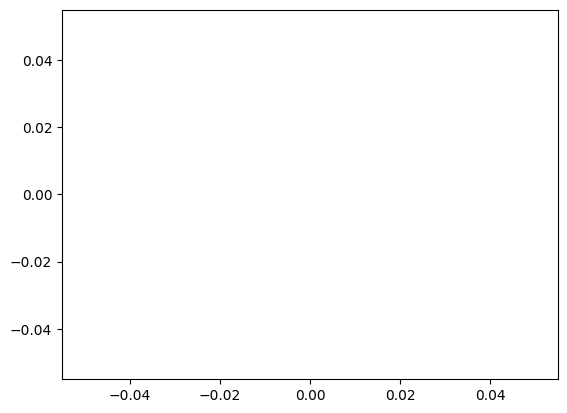

In [34]:
plt.plot(lr_l,loss_l)

So -1 to -0.5, somewhere here we can set our learning rate.

In [35]:
# loss for the whole data

emb = C[X]

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
loss.item()

2.3589489459991455

We split them into train, dev/validation, test sets   

Train -> 80%  (optimize the parameters of the model)   

dev/validation -> 10% (This one is for model hyper-tuning, the size of the hidden layer, the size of the embedding, number of hidden layers etc.)  
 
Test -> 10% (Evaluate the performance of the model at the end.)

In [36]:
# Build the dataset
import random
from typing import List

def build_dataset(words: List[str], context_len: int=3):
    block_size = context_len 
    
    X,Y = [],[]

    block_size = 3

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    # print(X)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y
    # X.shape, X.dtype, Y.shape, Y.dtype


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,Y_train = build_dataset(words[:n1],3)
X_dev,Y_dev = build_dataset(words[n1:n2],3)
X_test,Y_test = build_dataset(words[n2:],3)

X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [37]:
# Now lets train w.r.t X_Train, Y_train
g = torch.Generator().manual_seed(21)
W1 = torch.randn((6,100),generator=g) # 100 neurons with 6 intakes each.
b1 = torch.randn(100,generator=g) 
W2 = torch.rand((100,27),generator=g)
b2 = torch.rand(27,generator=g)
parameters = [C, W1, b1, W2, b2]
print("Number of paramters in our model: ", sum(p.nelement() for p in parameters))

Number of paramters in our model:  3481


In [38]:
# adding mini-batch logic
lr_l = []
loss_l = []

for p in parameters:
    p.requires_grad = True

for epoch in range(10000):
    ix = torch.randint(0, X_train.shape[0], (32,))

    emb = C[X_train[ix]]

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Y_train[ix])

    # print(f'Epoch: {epoch}',loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    # lr = lrs[epoch]

    for p in parameters:
        p.data += -0.1*p.grad
    
    # lr_l.append(lre[epoch])
    # loss_l.append(loss.item())
    
    
print(loss.item())

2.2102086544036865


In [39]:
# Loss on Training Set
emb = C[X_train]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_train)
print('Evaluated Loss on TrainingSet for our model: ',loss.item())

Evaluated Loss on TrainingSet for our model:  2.3698344230651855


In [40]:
# Evaluating w.r.t Dev
emb = C[X_dev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_dev)
print('Evaluated Loss on Dev for our model: ',loss.item())

Evaluated Loss on Dev for our model:  2.36213755607605


We observe the training and dev loss are kinda close, which means we are not overfitting, which means the model is not powerful enough to memorize the data. Its kinda underfitting as the training_loss and dev_loss are roughly equal which means our network is very tiny. So we will make improvements by scaling up the size of the neural net.


### Bigger Neural Net

In [41]:
# Now lets train w.r.t X_Train, Y_train
g = torch.Generator().manual_seed(4567)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,300),generator=g) # 100 neurons with 6 intakes each.
b1 = torch.randn(300,generator=g) 
W2 = torch.rand((300,27),generator=g)
b2 = torch.rand(27,generator=g)
parameters = [C, W1, b1, W2, b2]
print("Number of paramters in our model: ", sum(p.nelement() for p in parameters))

Number of paramters in our model:  10281


In [42]:
# adding mini-batch logic
lr_l = []
loss_l = []
steps_l = []

for p in parameters:
    p.requires_grad = True

for epoch in range(30000):
    ix = torch.randint(0, X_train.shape[0], (32,))

    emb = C[X_train[ix]]

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Y_train[ix])

    # print(f'Epoch: {epoch}',loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    # lr = lrs[epoch]

    for p in parameters:
        p.data += -0.01*p.grad
    
    # lr_l.append(lre[epoch])
    steps_l.append(epoch)
    loss_l.append(loss.item())
    
    
print(loss.item())

2.025178909301758


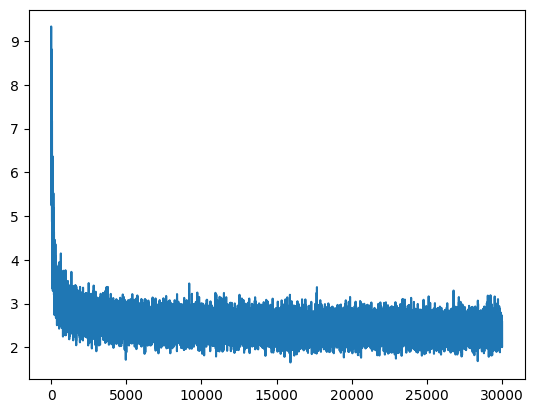

In [43]:
plt.plot(steps_l,loss_l)

We observe a thickness to this, its because we are optimizing the parameters on mini-batches (samples from train dataset) which leads to this noise.

One possibility is batch_size is too low, that we have way to much noise in the training. So lets increase the batch_size so that we are not thrashing very-much.

In [44]:
# Loss on Training Set
emb = C[X_train]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_train)
print('Evaluated Loss on TrainingSet for our model: ',loss.item())

# Evaluating w.r.t Dev
emb = C[X_dev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_dev)
print('Evaluated Loss on Dev for our model: ',loss.item())

Evaluated Loss on TrainingSet for our model:  2.388462781906128
Evaluated Loss on Dev for our model:  2.386636972427368


Here we have only changed the hidden layer size of our neural network.

But if the losses aren't coming down, then the bottleneck is the embedding layer (which are 2-dim), which we are cramming way to much characters into the 2-dimensional space and the neural net is not able to use that space effectively, hence becoming the bottleneck to our model's performance.

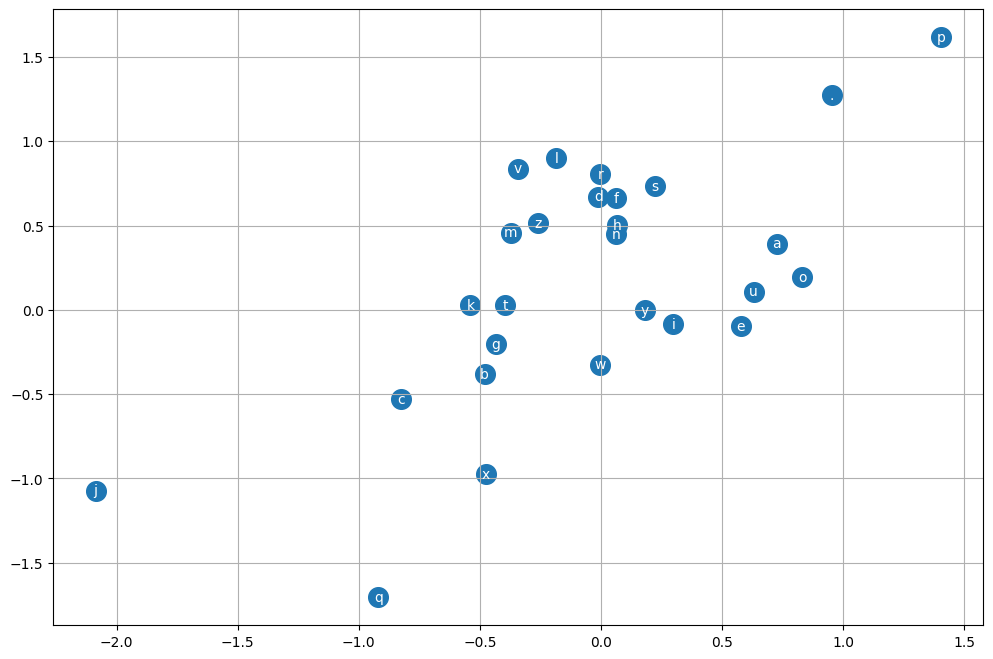

In [45]:
plt.figure(figsize=(12,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha='center',va='center',color='white')
plt.grid('minor')

If we observe vowels are little bit seperated from the rest of the group. q is an exception.

As the bottle-neck in our neural network is the embedding input layer lets add more dimensions into that.

### 10 Dimension embedding vector

In [47]:
# Now lets train w.r.t X_Train, Y_train
g = torch.Generator().manual_seed(4567)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g) # 100 neurons with 6 intakes each.
b1 = torch.randn(200,generator=g) 
W2 = torch.rand((200,27),generator=g)
b2 = torch.rand(27,generator=g)
parameters = [C, W1, b1, W2, b2]
print("Number of paramters in our model: ", sum(p.nelement() for p in parameters))

Number of paramters in our model:  11897


In [48]:
lr_l = []
loss_l = []
steps_l = []

In [55]:
# adding mini-batch logic

for p in parameters:
    p.requires_grad = True

for epoch in range(50000):
    ix = torch.randint(0, X_train.shape[0], (32,))

    emb = C[X_train[ix]]

    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits,Y_train[ix])

    # print(f'Epoch: {epoch}',loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    # lr = lrs[epoch]

    for p in parameters:
        p.data += -0.01*p.grad
    
    # lr_l.append(lre[epoch])
    steps_l.append(epoch)
    loss_l.append(loss.log10().item())
    
    
print(loss.item())

2.2292394638061523


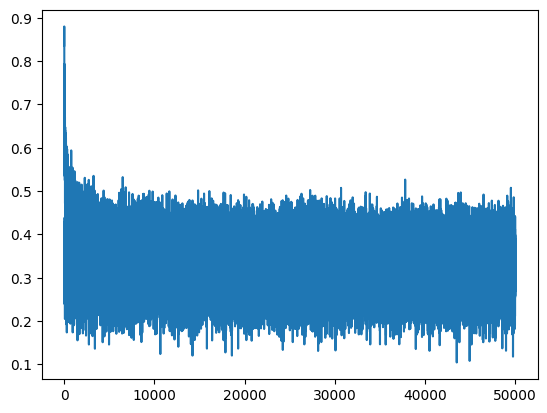

In [56]:
plt.plot(steps_l,loss_l)

### 1st 50000 iteration

In [51]:
# Loss on Training Set
emb = C[X_train]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_train)
print('Evaluated Loss on TrainingSet for our model: ',loss.item())

# Evaluating w.r.t Dev
emb = C[X_dev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_dev)
print('Evaluated Loss on Dev for our model: ',loss.item())

Evaluated Loss on TrainingSet for our model:  2.2086331844329834
Evaluated Loss on Dev for our model:  2.252385377883911


### 2nd 50000 iteration

In [54]:
# Loss on Training Set
emb = C[X_train]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_train)
print('Evaluated Loss on TrainingSet for our model: ',loss.item())

# Evaluating w.r.t Dev
emb = C[X_dev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_dev)
print('Evaluated Loss on Dev for our model: ',loss.item())

Evaluated Loss on TrainingSet for our model:  2.1063387393951416
Evaluated Loss on Dev for our model:  2.156723737716675


### 3rd 50000 iteration

In [57]:
# Loss on Training Set
emb = C[X_train]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_train)
print('Evaluated Loss on TrainingSet for our model: ',loss.item())

# Evaluating w.r.t Dev
emb = C[X_dev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_dev)
print('Evaluated Loss on Dev for our model: ',loss.item())

Evaluated Loss on TrainingSet for our model:  2.0988075733184814
Evaluated Loss on Dev for our model:  2.1489932537078857


Now see the difference between train_set loss and dev_set loss for the 3 iterations, initially they are close, but as we iterate/train more the model then tries to over-fit which leads to big difference in train_set data and dev set data.

In general we take a lot of parameters and then run experiments on it, the parameters which gives the best loss will be choosen and then the test_set is fed into the model. The loss obtained from the test_data will then be reported in the papers or the final acc/loss.

In [63]:
# Now lets generate few examples

g = torch.Generator().manual_seed(354)

for _ in range(10):

    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor(context)]
        # print(emb.shape)
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))



sara.
coer.
aveer.
amilly.
nylennalett.
xzuxlendriellie.
kayra.
jakenni.
mascye.
ridha.
